In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import psutil
import tensorflow as tf
from ultralytics import YOLO

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import torch
print("MPS Available: ", torch.backends.mps.is_available())


MPS Available:  True


In [4]:
model_path = r"mobilenet_v2"
with tf.device('/GPU:0'):
    mobilenet_model = tf.saved_model.load(model_path)


In [5]:


# Load YOLO model
yolo_model = YOLO('yolov8n.pt')

# Set device to mps (Metal Performance Shaders) for M2 Max
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Move the model to the specified device
yolo_model.to(device)
device

device(type='mps')

In [6]:
vehicle_classes = [1, 2, 3, 5, 7] 

In [7]:
def detect_objects_mobilenet(frame):
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, axis=0))
    detections = mobilenet_model(input_tensor)

    # Extract detection results
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    return boxes, scores

def detect_vehicles_yolo(frame):
    results = yolo_model.predict(frame,verbose=False) 
    vehicle_boxes = []
    
    for result in results:
        for bbox, cls_id, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            if int(cls_id) in vehicle_classes and conf > 0.5:
                x1, y1, x2, y2 = map(int, bbox)
                vehicle_boxes.append([x1, y1, x2, y2])
    
    return vehicle_boxes

In [8]:
def generate_heatmap_mobilenet(frame, heatmap):
    boxes, scores = detect_objects_mobilenet(frame)
    
    for i in range(len(scores)):
        if scores[i] >= 0.5:
            box = boxes[i]
            (ymin, xmin, ymax, xmax) = box
            (left, right, top, bottom) = (xmin * frame.shape[1], xmax * frame.shape[1],
                                           ymin * frame.shape[0], ymax * frame.shape[0])
            heatmap[int(top):int(bottom), int(left):int(right)] += 1
    
    return heatmap

def generate_heatmap_yolo(frame, heatmap):
    vehicle_boxes = detect_vehicles_yolo(frame)
    
    for (x1, y1, x2, y2) in vehicle_boxes:
        heatmap[y1:y2, x1:x2] += 1
    
    return heatmap

In [9]:
import matplotlib.pyplot as plt

In [10]:
def process_video(PATHH):
    cap = cv2.VideoCapture(PATHH)
    
    heatmap_mobilenet = np.zeros((480, 640), dtype=np.float32)
    heatmap_yolo = np.zeros((480, 640), dtype=np.float32)
    
    inference_times_mobilenet = []
    inference_times_yolo = []
    
    cpu_usage_mobilenet = []
    cpu_usage_yolo = []
    
    mem_usage_mobilenet = []
    mem_usage_yolo = []
    
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video")
        return
    plt.ion()  # Interactive mode on
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (640, 480))

        start_time = time.time()
        heatmap_mobilenet = generate_heatmap_mobilenet(frame_resized, heatmap_mobilenet)
        inference_time = time.time() - start_time
        inference_times_mobilenet.append(inference_time)

        cpu_usage_mobilenet.append(psutil.cpu_percent())
        mem_usage_mobilenet.append(psutil.virtual_memory().percent)

        start_time = time.time()
        heatmap_yolo = generate_heatmap_yolo(frame_resized, heatmap_yolo)
        inference_time = time.time() - start_time
        inference_times_yolo.append(inference_time)

        cpu_usage_yolo.append(psutil.cpu_percent())
        mem_usage_yolo.append(psutil.virtual_memory().percent)

        ax[0].imshow(heatmap_mobilenet, cmap='hot', interpolation='nearest')
        ax[0].set_title('Heatmap - MobileNet V2')
        ax[1].imshow(heatmap_yolo, cmap='hot', interpolation='nearest')
        ax[1].set_title('Heatmap - YOLO')

    cap.release()
    plt.ioff()  # Turn off interactive mode
    plt.show() 
    return (inference_times_mobilenet, inference_times_yolo,
            cpu_usage_mobilenet, cpu_usage_yolo,
            mem_usage_mobilenet, mem_usage_yolo,
            heatmap_mobilenet, heatmap_yolo)




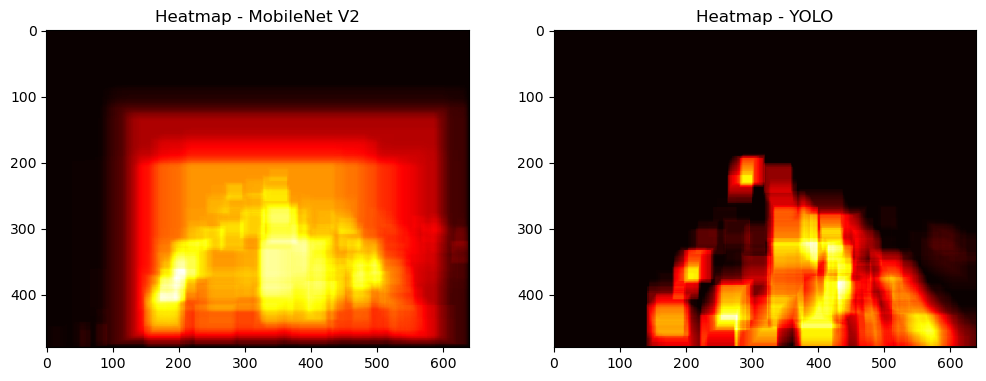

In [11]:
inference_times_mobilenet, inference_times_yolo, \
cpu_usage_mobilenet, cpu_usage_yolo, \
mem_usage_mobilenet, mem_usage_yolo, \
heatmap_mobilenet, heatmap_yolo = process_video('video.mp4')

In [13]:
import json

In [14]:
result_dict = {
    'inference_times_mobilenet': inference_times_mobilenet,
    'inference_times_yolo': inference_times_yolo,
    'cpu_usage_mobilenet': cpu_usage_mobilenet,
    'cpu_usage_yolo': cpu_usage_yolo,
    'mem_usage_mobilenet': mem_usage_mobilenet,
    'mem_usage_yolo': mem_usage_yolo,
    'heatmap_mobilenet': heatmap_mobilenet.tolist(),
    'heatmap_yolo': heatmap_yolo.tolist()
}

# Save to a JSON file
with open('resultGPU.json', 'w') as json_file:
    json.dump(result_dict, json_file, indent=4)



In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import psutil
import tensorflow as tf
from ultralytics import YOLO
import json
import torch

In [8]:
tf.config.set_visible_devices([], 'GPU')  # Disable GPU for TensorFlow
print("Num GPUs Available (TensorFlow):", len(tf.config.list_physical_devices('GPU')))  # Should be 0


Num GPUs Available (TensorFlow): 1


In [9]:
model_path = r"mobilenet_v2"
with tf.device('/CPU:0'):
    mobilenet_model = tf.saved_model.load(model_path)

In [10]:
yolo_model = YOLO('yolov8n.pt')
device = torch.device('cpu')  # Set device to CPU
yolo_model.to(device)  
device

device(type='cpu')

In [11]:
vehicle_classes = [1, 2, 3, 5, 7]

In [12]:
def detect_objects_mobilenet(frame):
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, axis=0))
    detections = mobilenet_model(input_tensor)
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    return boxes, scores

# YOLO detection
def detect_vehicles_yolo(frame):
    results = yolo_model.predict(frame, verbose=False)
    vehicle_boxes = []
    
    for result in results:
        for bbox, cls_id, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            if int(cls_id) in vehicle_classes and conf > 0.5:
                x1, y1, x2, y2 = map(int, bbox)
                vehicle_boxes.append([x1, y1, x2, y2])
    
    return vehicle_boxes

In [13]:
def generate_heatmap_mobilenet(frame, heatmap):
    boxes, scores = detect_objects_mobilenet(frame)
    for i in range(len(scores)):
        if scores[i] >= 0.5:
            box = boxes[i]
            ymin, xmin, ymax, xmax = box
            left, right, top, bottom = (xmin * frame.shape[1], xmax * frame.shape[1], ymin * frame.shape[0], ymax * frame.shape[0])
            heatmap[int(top):int(bottom), int(left):int(right)] += 1
    return heatmap

# Generate heatmap for YOLO
def generate_heatmap_yolo(frame, heatmap):
    vehicle_boxes = detect_vehicles_yolo(frame)
    for x1, y1, x2, y2 in vehicle_boxes:
        heatmap[y1:y2, x1:x2] += 1
    return heatmap

In [14]:
def process_video(PATHH):
    cap = cv2.VideoCapture(PATHH)
    heatmap_mobilenet = np.zeros((480, 640), dtype=np.float32)
    heatmap_yolo = np.zeros((480, 640), dtype=np.float32)
    
    inference_times_mobilenet = []
    inference_times_yolo = []
    cpu_usage_mobilenet = []
    cpu_usage_yolo = []
    mem_usage_mobilenet = []
    mem_usage_yolo = []
    
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video")
        return

    plt.ion()  # Interactive mode on
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (640, 480))

        start_time = time.time()
        heatmap_mobilenet = generate_heatmap_mobilenet(frame_resized, heatmap_mobilenet)
        inference_time = time.time() - start_time
        inference_times_mobilenet.append(inference_time)

        cpu_usage_mobilenet.append(psutil.cpu_percent())
        mem_usage_mobilenet.append(psutil.virtual_memory().percent)

        start_time = time.time()
        heatmap_yolo = generate_heatmap_yolo(frame_resized, heatmap_yolo)
        inference_time = time.time() - start_time
        inference_times_yolo.append(inference_time)

        cpu_usage_yolo.append(psutil.cpu_percent())
        mem_usage_yolo.append(psutil.virtual_memory().percent)

        ax[0].imshow(heatmap_mobilenet, cmap='hot', interpolation='nearest')
        ax[0].set_title('Heatmap - MobileNet V2')
        ax[1].imshow(heatmap_yolo, cmap='hot', interpolation='nearest')
        ax[1].set_title('Heatmap - YOLO')

    cap.release()
    plt.ioff()  # Turn off interactive mode
    plt.show()

    return (inference_times_mobilenet, inference_times_yolo,
            cpu_usage_mobilenet, cpu_usage_yolo,
            mem_usage_mobilenet, mem_usage_yolo,
            heatmap_mobilenet, heatmap_yolo)

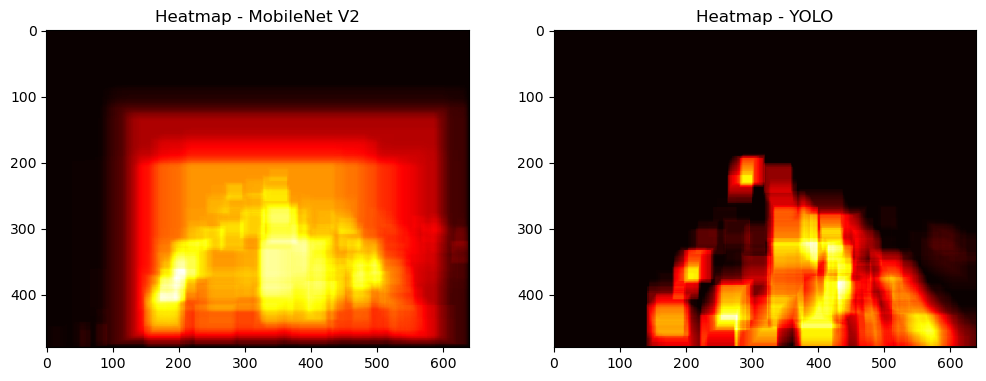

In [15]:
inference_times_mobilenet, inference_times_yolo, \
cpu_usage_mobilenet, cpu_usage_yolo, \
mem_usage_mobilenet, mem_usage_yolo, \
heatmap_mobilenet, heatmap_yolo = process_video('video.mp4')



In [16]:
# Save the results to a JSON file
result_dict = {
    'inference_times_mobilenet': inference_times_mobilenet,
    'inference_times_yolo': inference_times_yolo,
    'cpu_usage_mobilenet': cpu_usage_mobilenet,
    'cpu_usage_yolo': cpu_usage_yolo,
    'mem_usage_mobilenet': mem_usage_mobilenet,
    'mem_usage_yolo': mem_usage_yolo,
    'heatmap_mobilenet': heatmap_mobilenet.tolist(),
    'heatmap_yolo': heatmap_yolo.tolist()
}

with open('resultCPU.json', 'w') as json_file:
    json.dump(result_dict, json_file, indent=4)

In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON files
with open('resultGPU.json', 'r') as json_file:
    result_gpu_data = json.load(json_file)

with open('resultCPU.json', 'r') as json_file:
    result_cpu_data = json.load(json_file)

# Extract data from the loaded JSON
# From GPU data (resultGPU.json)
inference_times_mobilenet_gpu = result_gpu_data['inference_times_mobilenet']
inference_times_yolo_gpu = result_gpu_data['inference_times_yolo']
cpu_usage_mobilenet_gpu = result_gpu_data['cpu_usage_mobilenet']
cpu_usage_yolo_gpu = result_gpu_data['cpu_usage_yolo']
mem_usage_mobilenet_gpu = result_gpu_data['mem_usage_mobilenet']
mem_usage_yolo_gpu = result_gpu_data['mem_usage_yolo']
heatmap_mobilenet_gpu = np.array(result_gpu_data['heatmap_mobilenet'])
heatmap_yolo_gpu = np.array(result_gpu_data['heatmap_yolo'])

# From CPU data (resultCPU.json)
inference_times_mobilenet_cpu = result_cpu_data['inference_times_mobilenet']
inference_times_yolo_cpu = result_cpu_data['inference_times_yolo']
cpu_usage_mobilenet_cpu = result_cpu_data['cpu_usage_mobilenet']
cpu_usage_yolo_cpu = result_cpu_data['cpu_usage_yolo']
mem_usage_mobilenet_cpu = result_cpu_data['mem_usage_mobilenet']
mem_usage_yolo_cpu = result_cpu_data['mem_usage_yolo']
heatmap_mobilenet_cpu = np.array(result_cpu_data['heatmap_mobilenet'])
heatmap_yolo_cpu = np.array(result_cpu_data['heatmap_yolo'])

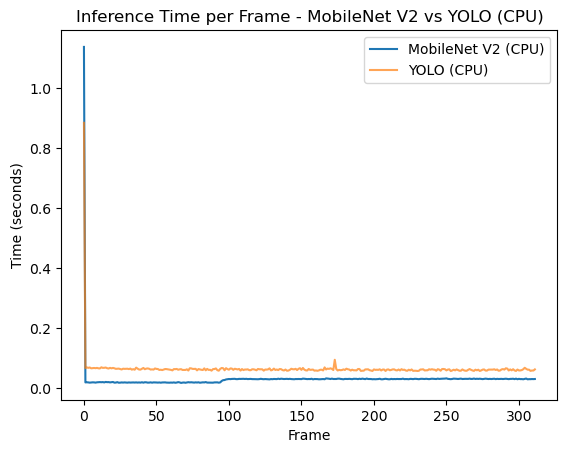

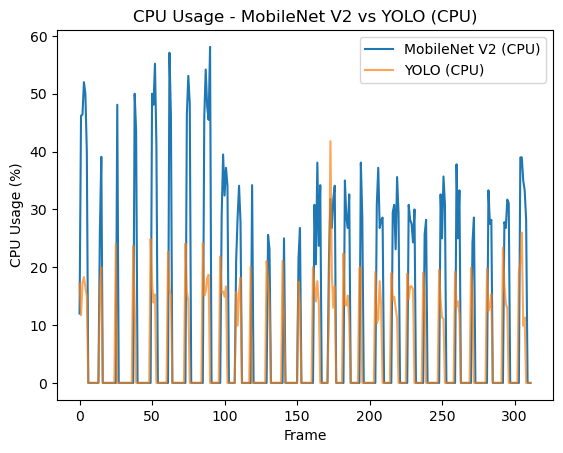

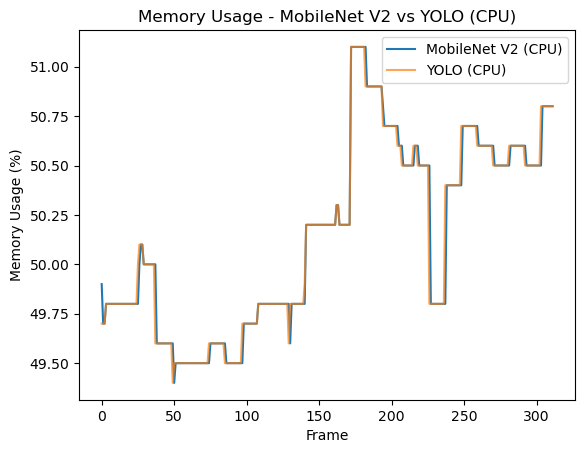

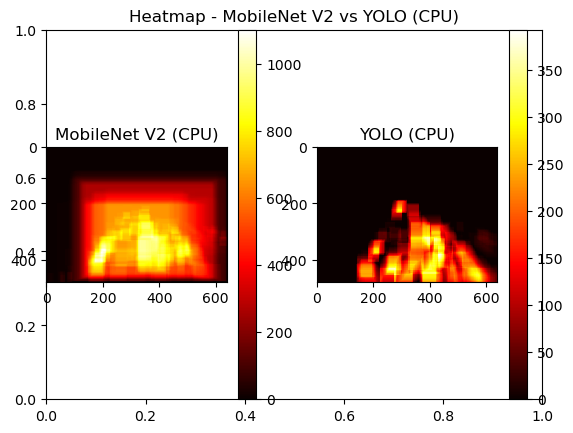

In [25]:
# --- 1. MobileNet V2 (CPU) vs YOLO (CPU) ---
plt.figure()
plt.plot(inference_times_mobilenet_cpu, label='MobileNet V2 (CPU)')
plt.plot(inference_times_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.title('Inference Time per Frame - MobileNet V2 vs YOLO (CPU)')
plt.xlabel('Frame')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

plt.figure()
plt.plot(cpu_usage_mobilenet_cpu, label='MobileNet V2 (CPU)')
plt.plot(cpu_usage_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.title('CPU Usage - MobileNet V2 vs YOLO (CPU)')
plt.xlabel('Frame')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.plot(mem_usage_mobilenet_cpu, label='MobileNet V2 (CPU)')
plt.plot(mem_usage_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.title('Memory Usage - MobileNet V2 vs YOLO (CPU)')
plt.xlabel('Frame')
plt.ylabel('Memory Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.title('Heatmap - MobileNet V2 vs YOLO (CPU)')
plt.subplot(1, 2, 1)
plt.imshow(heatmap_mobilenet_cpu, cmap='hot', interpolation='nearest')
plt.title('MobileNet V2 (CPU)')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(heatmap_yolo_cpu, cmap='hot', interpolation='nearest')
plt.title('YOLO (CPU)')
plt.colorbar()
plt.show()

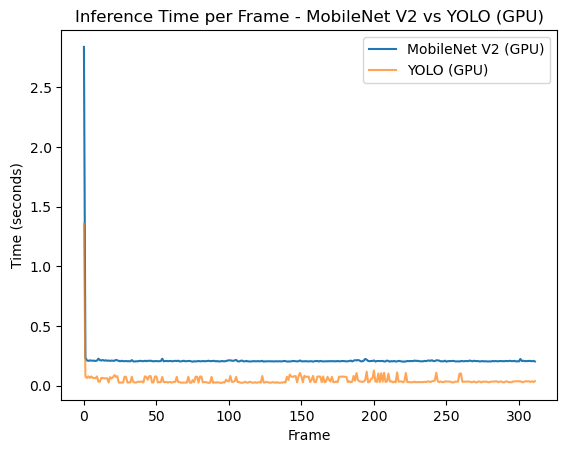

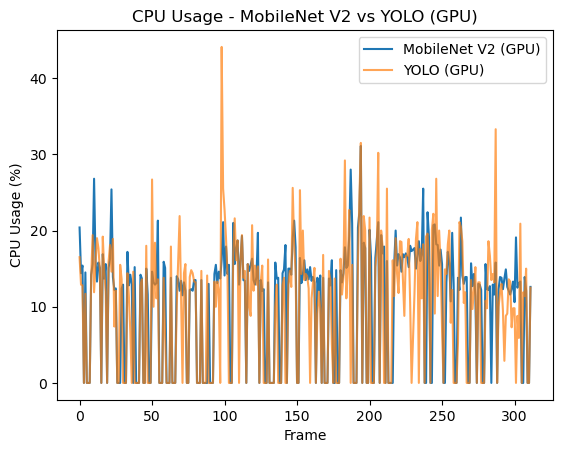

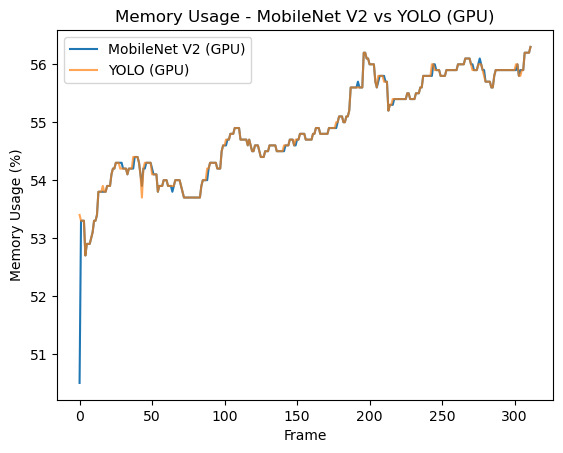

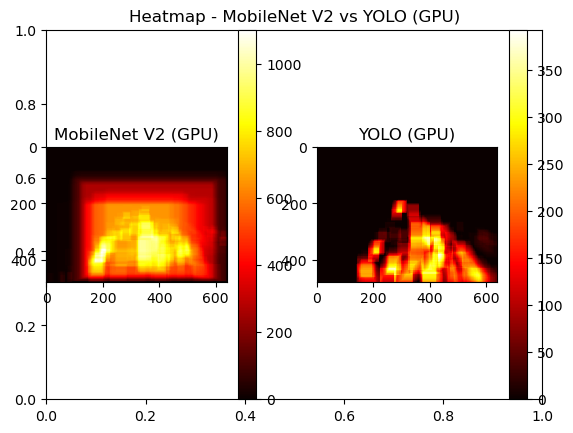

In [26]:
# --- 2. MobileNet V2 (GPU) vs YOLO (GPU) ---
plt.figure()
plt.plot(inference_times_mobilenet_gpu, label='MobileNet V2 (GPU)')
plt.plot(inference_times_yolo_gpu, label='YOLO (GPU)', alpha=0.7)
plt.title('Inference Time per Frame - MobileNet V2 vs YOLO (GPU)')
plt.xlabel('Frame')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

plt.figure()
plt.plot(cpu_usage_mobilenet_gpu, label='MobileNet V2 (GPU)')
plt.plot(cpu_usage_yolo_gpu, label='YOLO (GPU)', alpha=0.7)
plt.title('CPU Usage - MobileNet V2 vs YOLO (GPU)')
plt.xlabel('Frame')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.plot(mem_usage_mobilenet_gpu, label='MobileNet V2 (GPU)')
plt.plot(mem_usage_yolo_gpu, label='YOLO (GPU)', alpha=0.7)
plt.title('Memory Usage - MobileNet V2 vs YOLO (GPU)')
plt.xlabel('Frame')
plt.ylabel('Memory Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.title('Heatmap - MobileNet V2 vs YOLO (GPU)')
plt.subplot(1, 2, 1)
plt.imshow(heatmap_mobilenet_gpu, cmap='hot', interpolation='nearest')
plt.title('MobileNet V2 (GPU)')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(heatmap_yolo_gpu, cmap='hot', interpolation='nearest')
plt.title('YOLO (GPU)')
plt.colorbar()
plt.show()



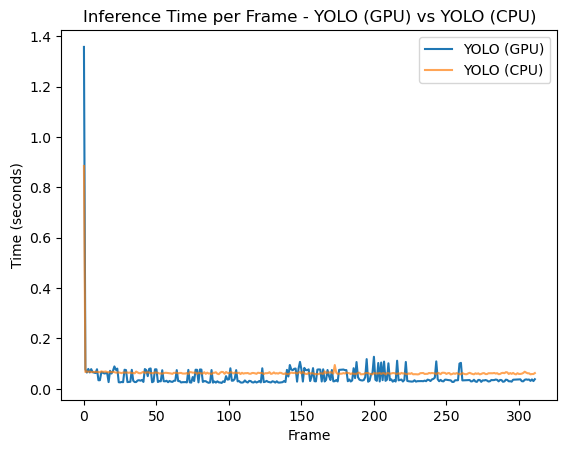

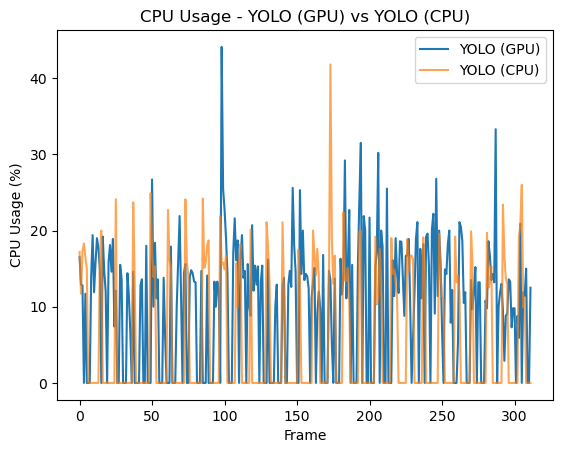

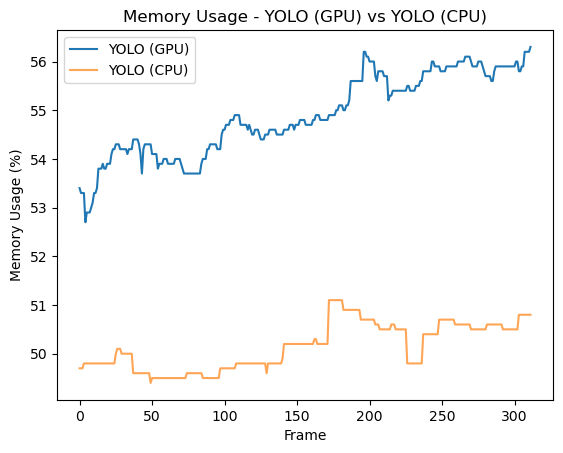

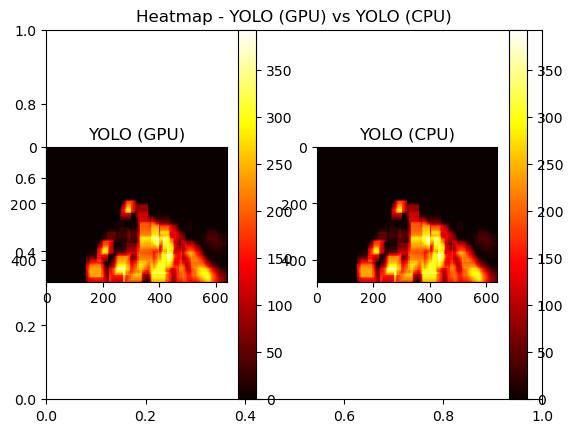

In [27]:
# --- 3. YOLO (GPU) vs YOLO (CPU) ---
plt.figure()
plt.plot(inference_times_yolo_gpu, label='YOLO (GPU)')
plt.plot(inference_times_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.title('Inference Time per Frame - YOLO (GPU) vs YOLO (CPU)')
plt.xlabel('Frame')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

plt.figure()
plt.plot(cpu_usage_yolo_gpu, label='YOLO (GPU)')
plt.plot(cpu_usage_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.title('CPU Usage - YOLO (GPU) vs YOLO (CPU)')
plt.xlabel('Frame')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.plot(mem_usage_yolo_gpu, label='YOLO (GPU)')
plt.plot(mem_usage_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.title('Memory Usage - YOLO (GPU) vs YOLO (CPU)')
plt.xlabel('Frame')
plt.ylabel('Memory Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.title('Heatmap - YOLO (GPU) vs YOLO (CPU)')
plt.subplot(1, 2, 1)
plt.imshow(heatmap_yolo_gpu, cmap='hot', interpolation='nearest')
plt.title('YOLO (GPU)')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(heatmap_yolo_cpu, cmap='hot', interpolation='nearest')
plt.title('YOLO (CPU)')
plt.colorbar()
plt.show()



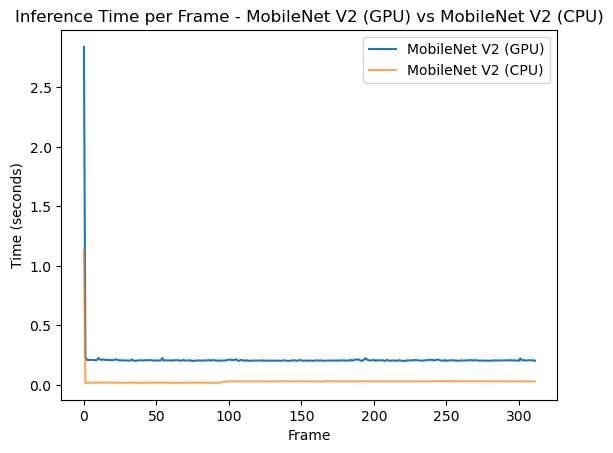

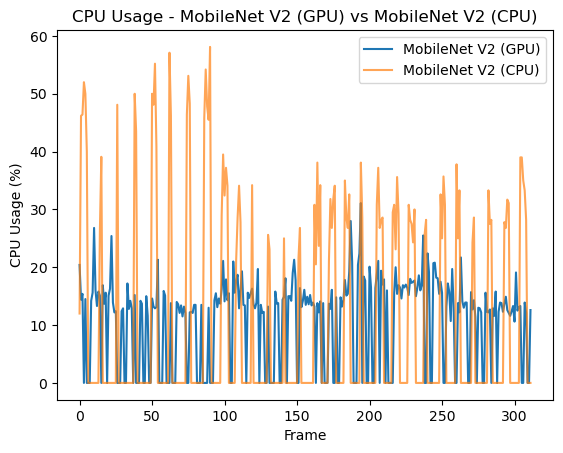

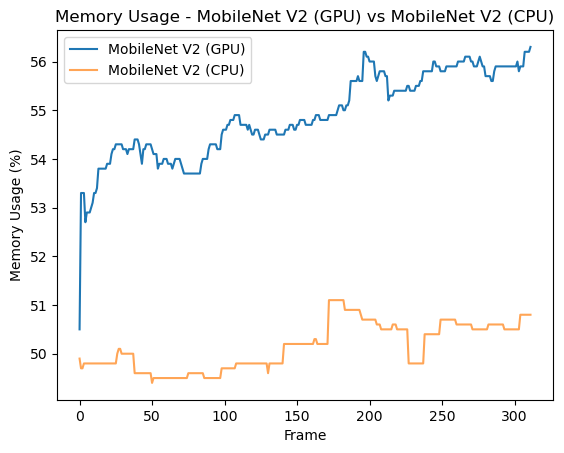

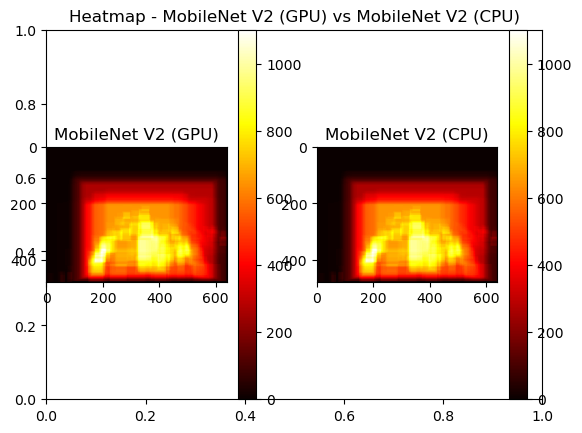

In [28]:
# --- 4. MobileNet V2 (GPU) vs MobileNet V2 (CPU) ---
plt.figure()
plt.plot(inference_times_mobilenet_gpu, label='MobileNet V2 (GPU)')
plt.plot(inference_times_mobilenet_cpu, label='MobileNet V2 (CPU)', alpha=0.7)
plt.title('Inference Time per Frame - MobileNet V2 (GPU) vs MobileNet V2 (CPU)')
plt.xlabel('Frame')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

plt.figure()
plt.plot(cpu_usage_mobilenet_gpu, label='MobileNet V2 (GPU)')
plt.plot(cpu_usage_mobilenet_cpu, label='MobileNet V2 (CPU)', alpha=0.7)
plt.title('CPU Usage - MobileNet V2 (GPU) vs MobileNet V2 (CPU)')
plt.xlabel('Frame')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.plot(mem_usage_mobilenet_gpu, label='MobileNet V2 (GPU)')
plt.plot(mem_usage_mobilenet_cpu, label='MobileNet V2 (CPU)', alpha=0.7)
plt.title('Memory Usage - MobileNet V2 (GPU) vs MobileNet V2 (CPU)')
plt.xlabel('Frame')
plt.ylabel('Memory Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.title('Heatmap - MobileNet V2 (GPU) vs MobileNet V2 (CPU)')
plt.subplot(1, 2, 1)
plt.imshow(heatmap_mobilenet_gpu, cmap='hot', interpolation='nearest')
plt.title('MobileNet V2 (GPU)')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(heatmap_mobilenet_cpu, cmap='hot', interpolation='nearest')
plt.title('MobileNet V2 (CPU)')
plt.colorbar()
plt.show()

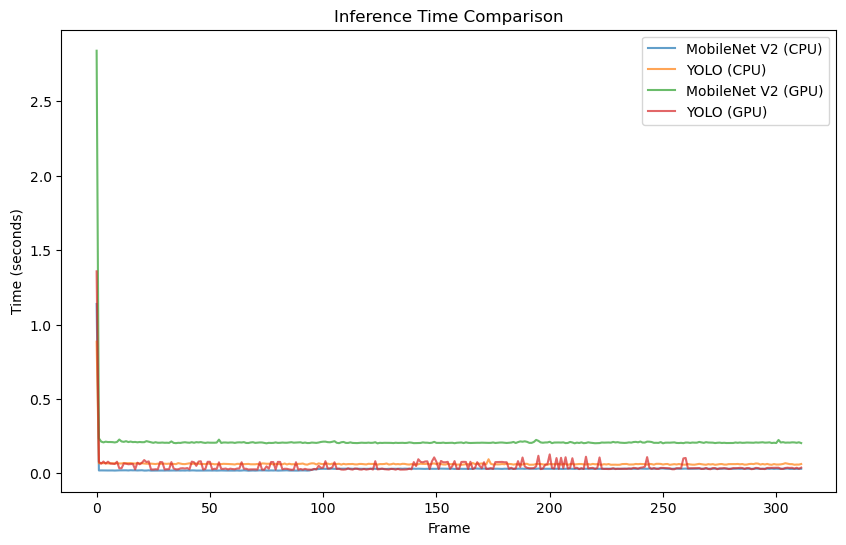

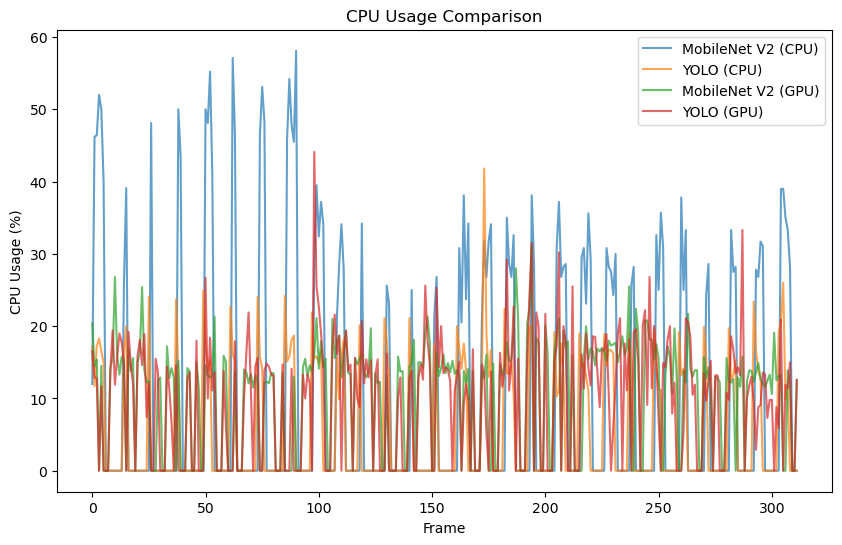

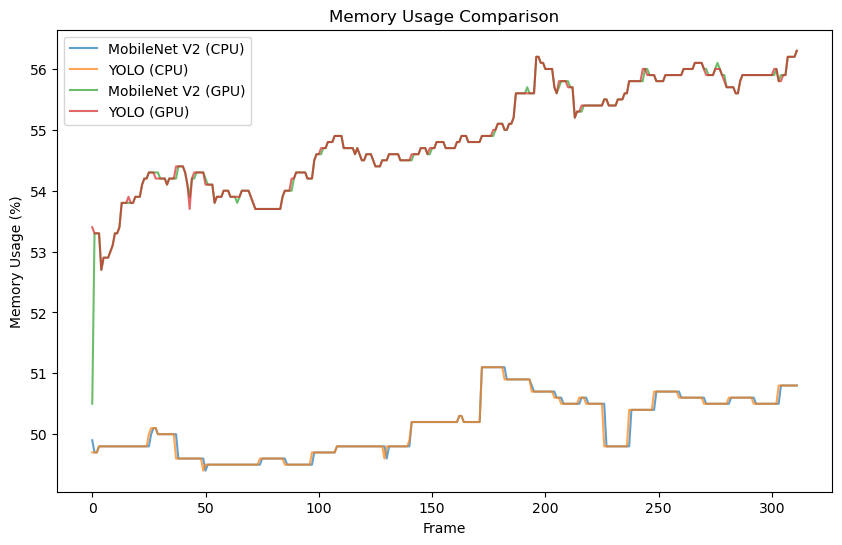

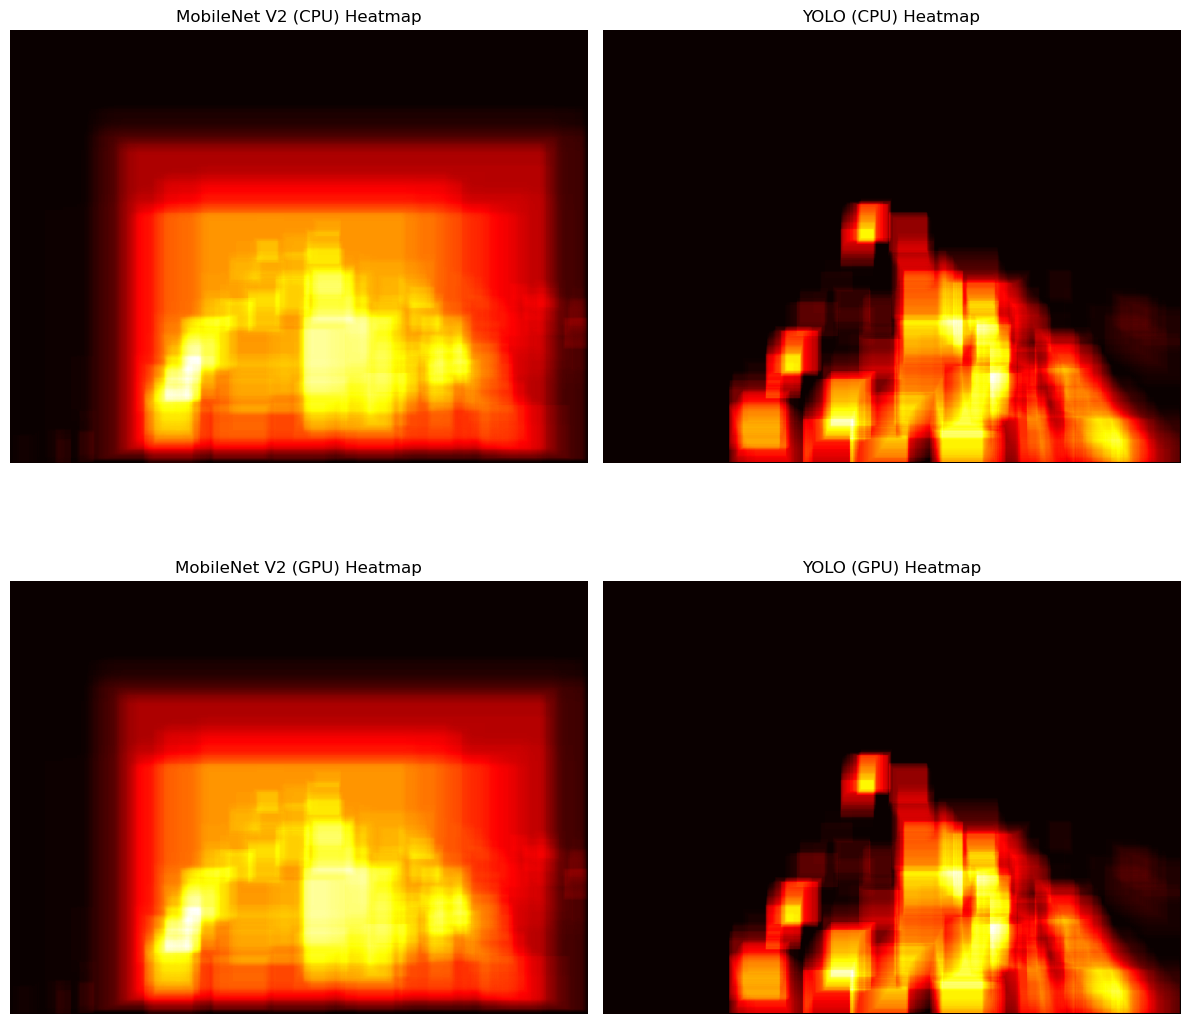

In [30]:
# --- Inference Time Plot ---
plt.figure(figsize=(10, 6))
plt.plot(inference_times_mobilenet_cpu, label='MobileNet V2 (CPU)', alpha=0.7)
plt.plot(inference_times_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.plot(inference_times_mobilenet_gpu, label='MobileNet V2 (GPU)', alpha=0.7)
plt.plot(inference_times_yolo_gpu, label='YOLO (GPU)', alpha=0.7)
plt.title('Inference Time Comparison')
plt.xlabel('Frame')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

# --- CPU Usage Plot ---
plt.figure(figsize=(10, 6))
plt.plot(cpu_usage_mobilenet_cpu, label='MobileNet V2 (CPU)', alpha=0.7)
plt.plot(cpu_usage_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.plot(cpu_usage_mobilenet_gpu, label='MobileNet V2 (GPU)', alpha=0.7)
plt.plot(cpu_usage_yolo_gpu, label='YOLO (GPU)', alpha=0.7)
plt.title('CPU Usage Comparison')
plt.xlabel('Frame')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

# --- Memory Usage Plot ---
plt.figure(figsize=(10, 6))
plt.plot(mem_usage_mobilenet_cpu, label='MobileNet V2 (CPU)', alpha=0.7)
plt.plot(mem_usage_yolo_cpu, label='YOLO (CPU)', alpha=0.7)
plt.plot(mem_usage_mobilenet_gpu, label='MobileNet V2 (GPU)', alpha=0.7)
plt.plot(mem_usage_yolo_gpu, label='YOLO (GPU)', alpha=0.7)
plt.title('Memory Usage Comparison')
plt.xlabel('Frame')
plt.ylabel('Memory Usage (%)')
plt.legend()
plt.show()

# --- Heatmap Plot with Subplots ---
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# MobileNet V2 (CPU)
ax[0, 0].imshow(heatmap_mobilenet_cpu, cmap='hot', interpolation='nearest')
ax[0, 0].set_title('MobileNet V2 (CPU) Heatmap')
ax[0, 0].axis('off')  # Hide axes

# YOLO (CPU)
ax[0, 1].imshow(heatmap_yolo_cpu, cmap='hot', interpolation='nearest')
ax[0, 1].set_title('YOLO (CPU) Heatmap')
ax[0, 1].axis('off')  # Hide axes

# MobileNet V2 (GPU)
ax[1, 0].imshow(heatmap_mobilenet_gpu, cmap='hot', interpolation='nearest')
ax[1, 0].set_title('MobileNet V2 (GPU) Heatmap')
ax[1, 0].axis('off')  # Hide axes

# YOLO (GPU)
ax[1, 1].imshow(heatmap_yolo_gpu, cmap='hot', interpolation='nearest')
ax[1, 1].set_title('YOLO (GPU) Heatmap')
ax[1, 1].axis('off')  # Hide axes

plt.tight_layout()
plt.show()